In [70]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data


def get_spectrogram(data, fs=2):
    """
    Get spectrogram from raw audio data
    :param data: raw audio data
    :param fs:
    :return:
    """

    nchannels = data.ndim

    if nchannels > 1:
        data = data[:, 0]

    pxx, _, _ = mlab.specgram(data, NFFT, fs, noverlap=int(NFFT / 2))

    return pxx


def spectrogram_from_file(wav_file, fs=2):
    """
    Calculate and plot spectrogram for a wav audio file
    :param wav_file: path to the wav file
    :param fs: Sampling frequencies
    :return: spectrogram
    """
    rate, data = get_wav_info(wav_file)

    return get_spectrogram(data, fs)


# Load raw audio files for speech synthesis
def load_raw_audio():
    positives = {}
    backgrounds = []
    negatives = []

    for filepath in glob.glob("{}/positives/*/*.wav".format(RAW_DATA_DIR)):
        label = filepath.split("/")[-2]
        positive = AudioSegment.from_wav(filepath).set_frame_rate(FRAME_RATE).set_channels(1)
        positives.setdefault(label, [])
        positives[label].append(positive)

    for filepath in glob.glob("{}/backgrounds/*.wav".format(RAW_DATA_DIR)):
        background = AudioSegment.from_wav(filepath).set_frame_rate(FRAME_RATE).set_channels(1)
        backgrounds.append(background)

    for filepath in glob.glob("{}/negatives/*.wav".format(RAW_DATA_DIR)):
        negative = AudioSegment.from_wav(filepath).set_frame_rate(FRAME_RATE).set_channels(1)
        negatives.append(negative)

    return positives, negatives, backgrounds


def get_random_time_segment(segment_ms, background_duration_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    :param segment_ms: the duration of the audio clip in ms ("ms" stands for "milliseconds")
    :param background_duration_ms: the background duration of the audio clip in ms
    :return: tuple of (segment_start, segment_end) in ms
    """

    segment_start = np.random.randint(low=0, high=background_duration_ms - segment_ms)
    segment_end = segment_start + segment_ms - 1

    return segment_start, segment_end


def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    :param segment_time: a tuple of (segment_start, segment_end) for the new segment
    :param previous_segments: a list of tuples of (segment_start, segment_end) for the existing segments
    :return: True if the time segment overlaps with any of the existing segments, False otherwise
    """

    segment_start, segment_end = segment_time

    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False

    # Step 2: loop over the previous_segments start and end times.
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap


def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the
    audio segment does not overlap with existing segments.
    :param background: background audio recording
    :param audio_clip: audio clip to be inserted/overlaid
    :param previous_segments: times where audio segments have already been placed
    :return: the updated background audio
    """

    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    # Get the duration of the background clip in ms
    background_duration_ms = len(background)

    segment_time = get_random_time_segment(segment_ms, background_duration_ms)

    i = 0
    while is_overlapping(segment_time, previous_segments):
        if i < 10:
            segment_time = get_random_time_segment(segment_ms, background_duration_ms)
            i += 1
        else:
            return background, (background_duration_ms, background_duration_ms)

    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position=segment_time[0])

    return new_background, segment_time


def cut_audio_segment(audio_segment, targeted_duration):
    """
    Cut the audio segment to the targeted duration randomly
    :param audio_segment: audio segment to cut
    :param targeted_duration: targeted_duration
    :return: the truncated audio segment
    """
    duration = len(audio_segment)
    if targeted_duration < duration:
        segment_start = np.random.randint(low=0, high=duration-targeted_duration)
        segment_end = segment_start + targeted_duration - 1
        return audio_segment[segment_start:segment_end]
    else:
        return audio_segment


def match_target_amplitude(sound, target_dBFS):
    """
    Used to standardize volume of audio clip
    :param sound: sound to standardize
    :param target_dBFS: targeted volume
    :return: standardized sound
    """
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


def insert_ones(y, y_label, segment_end_ms, background_duration_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    :param y: numpy array of shape (1, Ty), the labels of the training example
    :pram y_label: number otf the class we have to put 1
    :param segment_end_ms: the end time of the segment in ms
    :param background_duration_ms: duration of the background in ms
    :return:
    """

    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * TY / background_duration_ms)
    print(segment_end_y, segment_end_ms, background_duration_ms)

    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < TY:
            y[i, y_label] = 1
            y[i, 0] = 0

    return y


def transform_labels(y):
    """
    Save figure in sample dir to visualize our generated labels
    :param y: ndarray of shape (TY, N_CLASSES)
    :return: save file png
    """
    df = pd.DataFrame(y)
    return pd.concat([pd.DataFrame({'col': i, 'x': df.index, 'y': list(df[i])}) for i in df.columns])


def create_training_example(background, background_duration_ms, positives, negatives, n_export, export):
    """
    Creates a training example with a given background, activates, and negatives.

    :param background:   background audio recording
    :param background_duration_ms: background duration we want in ms
    :param positives: list of audio segments of the positives word we want to detect
    :param negatives: a list of audio segments of random words that we dont care about
    :return: tuple (x,y) with
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    background = cut_audio_segment(background, background_duration_ms)

    # Make background quieter
    background = match_target_amplitude(background, -45)

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((TY, N_CLASSES))
    y[:, 0] = 1

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []

    # Select 0-2 random "activate" audio clips from the entire list of "activates" recordings for 10 seconds record
    number_of_sound_to_add = np.random.randint(1, 3 * background_duration_ms / 5000)
    for i in range(number_of_sound_to_add):

        if np.random.random() > 1 / 3:

            # Take random positive with random label and get the right amplitude
            y_label, label = random.choice(list(enumerate(sorted(list(positives.keys())))))
            if MULTRIGGER_MODE:
                y_label += 1
            else:
                y_label = 1
            random_positive = random.choice(positives[label])
            random_positive = match_target_amplitude(random_positive, -20.0)
            # Insert the audio clip on the background
            background, segment_time = insert_audio_clip(background, random_positive, previous_segments)

            # Retrieve segment_start and segment_end from segment_time
            segment_start, segment_end = segment_time
            # Insert labels in "y"
            y = insert_ones(y, y_label, segment_end, background_duration_ms)

        else:

            # Take random negative and get the right amplitude
            random_negative = random.choice(negatives)
            random_negative = match_target_amplitude(random_negative, -20.0)
            background, _ = insert_audio_clip(background, random_negative, previous_segments)

    # Standardize the volume of the audio clip
    background = match_target_amplitude(background, -20.0)

    if export and (n_export % 50 == 0):
        # Export new training example
        file_name = "{}/sample-{}".format(INTERIM_DATA_DIR, n_export)
        background.export(file_name + ".wav", format="wav")

        #Export label as a graph
        df_y = transform_labels(y)
        sns.relplot(x='x', y='y', row='col', data=df_y, kind='line').savefig(file_name + ".png")

    background = np.array(background.get_array_of_samples())
    x = get_spectrogram(background)

    return np.swapaxes(x, 0, 1), y

In [52]:
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
import IPython

from pydub import AudioSegment


In [53]:
RAW_DATA_DIR = "../data/raw"
INTERIM_DATA_DIR = "../data/interim"
SAMPLE_DURATION_MS = 5000
KERNEL_SIZE = 15
STRIDE = 4
FRAME_RATE = 48000
NFFT = 512
TX = int(FRAME_RATE * 0.0195)
FX = int(NFFT / 2) + 1
MULTRIGGER_MODE = False
TY = round((TX - KERNEL_SIZE + STRIDE) / STRIDE)
N_CLASSES = 2

In [54]:
positives, negatives, backgrounds = load_raw_audio()

185 4007 5000


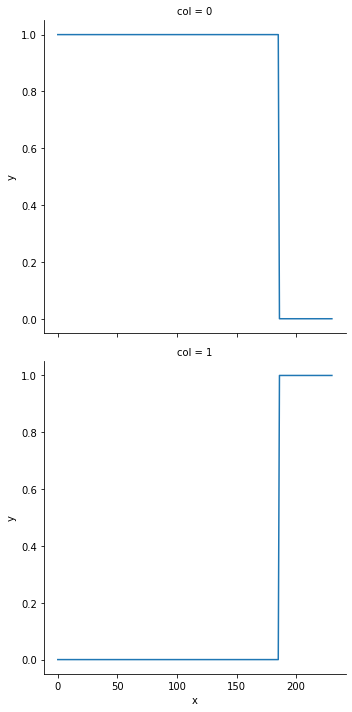

In [78]:
x, y = create_training_example(random.choice(backgrounds), SAMPLE_DURATION_MS, positives, negatives, 0, export = True)
IPython.display.Audio("{}/sample-0.wav".format(INTERIM_DATA_DIR))

In [68]:
transform_labels(y).tail()

,col,x,y
226,1,226,0.0
227,1,227,0.0
228,1,228,0.0
229,1,229,0.0
230,1,230,0.0
